In [1]:
import anndata as ad
import scanpy as sc

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from persist import PERSIST, ExpressionDataset

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'
sc.settings.datasetdir='../data/'

**Load and process dataset**

In [2]:


adata_raw = sc.datasets.pbmc3k()
adata = sc.datasets.pbmc3k_processed()

# get normalized data; the processed data contains negative values somehow. 
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)

# subset to the cells and genes in the procesed data
adata_raw = adata_raw[adata.obs.index].copy()
adata_raw = adata_raw[:, adata.var.index].copy()
adata.X = adata_raw.X
adata.layers['bin'] = (adata.X>0).astype(np.float32)

# We will use the clustered labels in the processed version for supervised mode of PERSIST. 
# louvain_id contains numeric entries. 
adata.obs["louvain_id"] = adata.obs["louvain"].cat.codes
display(adata.obs["louvain"].value_counts().to_frame())

,count
louvain,
CD4 T cells,1144
CD14+ Monocytes,480
B cells,342
CD8 T cells,316
NK cells,154
FCGR3A+ Monocytes,150
Dendritic cells,37
Megakaryocytes,15


**Create training and validation splits**

In [3]:
#use stratifiedkfold to split the data according to available labels
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
train_idx, test_idx = next(skf.split(adata.X, adata.obs["louvain_id"]))

adata_train = adata[train_idx]
adata_val = adata[test_idx]
df1 = adata_train.obs["louvain"].value_counts().to_frame()
df2 = adata_val.obs["louvain"].value_counts().to_frame()
df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=('_train', '_val'))
df.loc["Total"] = df.sum()
display(df)

,count_train,count_val
louvain,,
CD4 T cells,915,229
CD14+ Monocytes,384,96
B cells,273,69
CD8 T cells,252,64
NK cells,124,30
FCGR3A+ Monocytes,120,30
Dendritic cells,30,7
Megakaryocytes,12,3
Total,2110,528


**Run PERSIST**
 - Here the task is to select gene sets that can be used for cell type classification.
 - The reference is a scRNA-seq dataset, and the application might be selecting genes for an mFISH experiment where we want to recover cell type identity.
 - We choose input to be the binarized gene expression values to make results robust to domain shift (scRNA-seq vs. mFISH expression)
 - We use PERSIST with a cross entropy loss function, which is standard practice to train models for a classification problem. 

In [4]:
# Initialize the dataset for PERSIST
# Note: adata.X contains normalized values here. 
train_dataset = ExpressionDataset(adata_train.X, adata_train.obs['louvain_id'].values)
val_dataset = ExpressionDataset(adata_val.X, adata_val.obs['louvain_id'].values)


# Use GPU device if available -- we highly recommend using a GPU!
device = torch.device(torch.cuda.current_device() if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

# list of genes to select within the current selection process.
num_genes_list = [32]
persist_results = {}

# Set up the PERSIST selector; 
# We use the CrossEntropy loss since this is a classification task.
selector = PERSIST(train_dataset,
                   val_dataset,
                   loss_fn=torch.nn.CrossEntropyLoss(),
                   device=device)

# Coarse removal of genes
print('Starting initial elimination...')
candidates, model = selector.eliminate(target=500, max_nepochs=250)
print('Completed initial elimination.')

print('Selecting specific number of genes...')
for num in num_genes_list:
    inds, model = selector.select(num_genes=num, max_nepochs=250)
    persist_results[num] = inds
print('Done')

Using device: cuda:0
Starting initial elimination...
using CrossEntropyLoss, starting with lam = 0.0001


Training epochs:   0%|          | 0/250 [00:00<?, ?it/s]

lam = 0.000100 yielded 391 genes
Reinitializing model for next iteration
next attempt is lam = 0.000072


Training epochs:   0%|          | 0/250 [00:00<?, ?it/s]

lam = 0.000072 yielded 574 genes
done, lam = 0.000072 yielded 574 genes
Completed initial elimination.
Selecting specific number of genes...


Training epochs:   0%|          | 0/250 [00:00<?, ?it/s]

done, selected 32 genes
Done


In [5]:
# obtain a copy of features from the anndata object
# Note: Without the .copy(), you will modify adata itself, which may be desirable in some use cases.
df = adata.var.copy()

# set a boolean = True for genes selected in any of the rounds
for num in num_genes_list:
    df[f'persist_set_{num}'] = False
    ind = df.iloc[persist_results[num]].index
    df.loc[ind,f'persist_set_{num}'] = True

In [6]:
# only keep features (genes) that were selected in any set by PERSIST, and save for subsequent use
df = df[df[[f'persist_set_{num}' for num in num_genes_list]].any(axis=1)]
display(df.head(10))

,n_cells,persist_set_32
index,,
S100A8,743,True
FCER1A,55,True
FCGR3A,497,True
FCRLA,117,True
CD247,721,True
XCL2,138,True
G0S2,185,True
ID2,1040,True
ZAP70,383,True


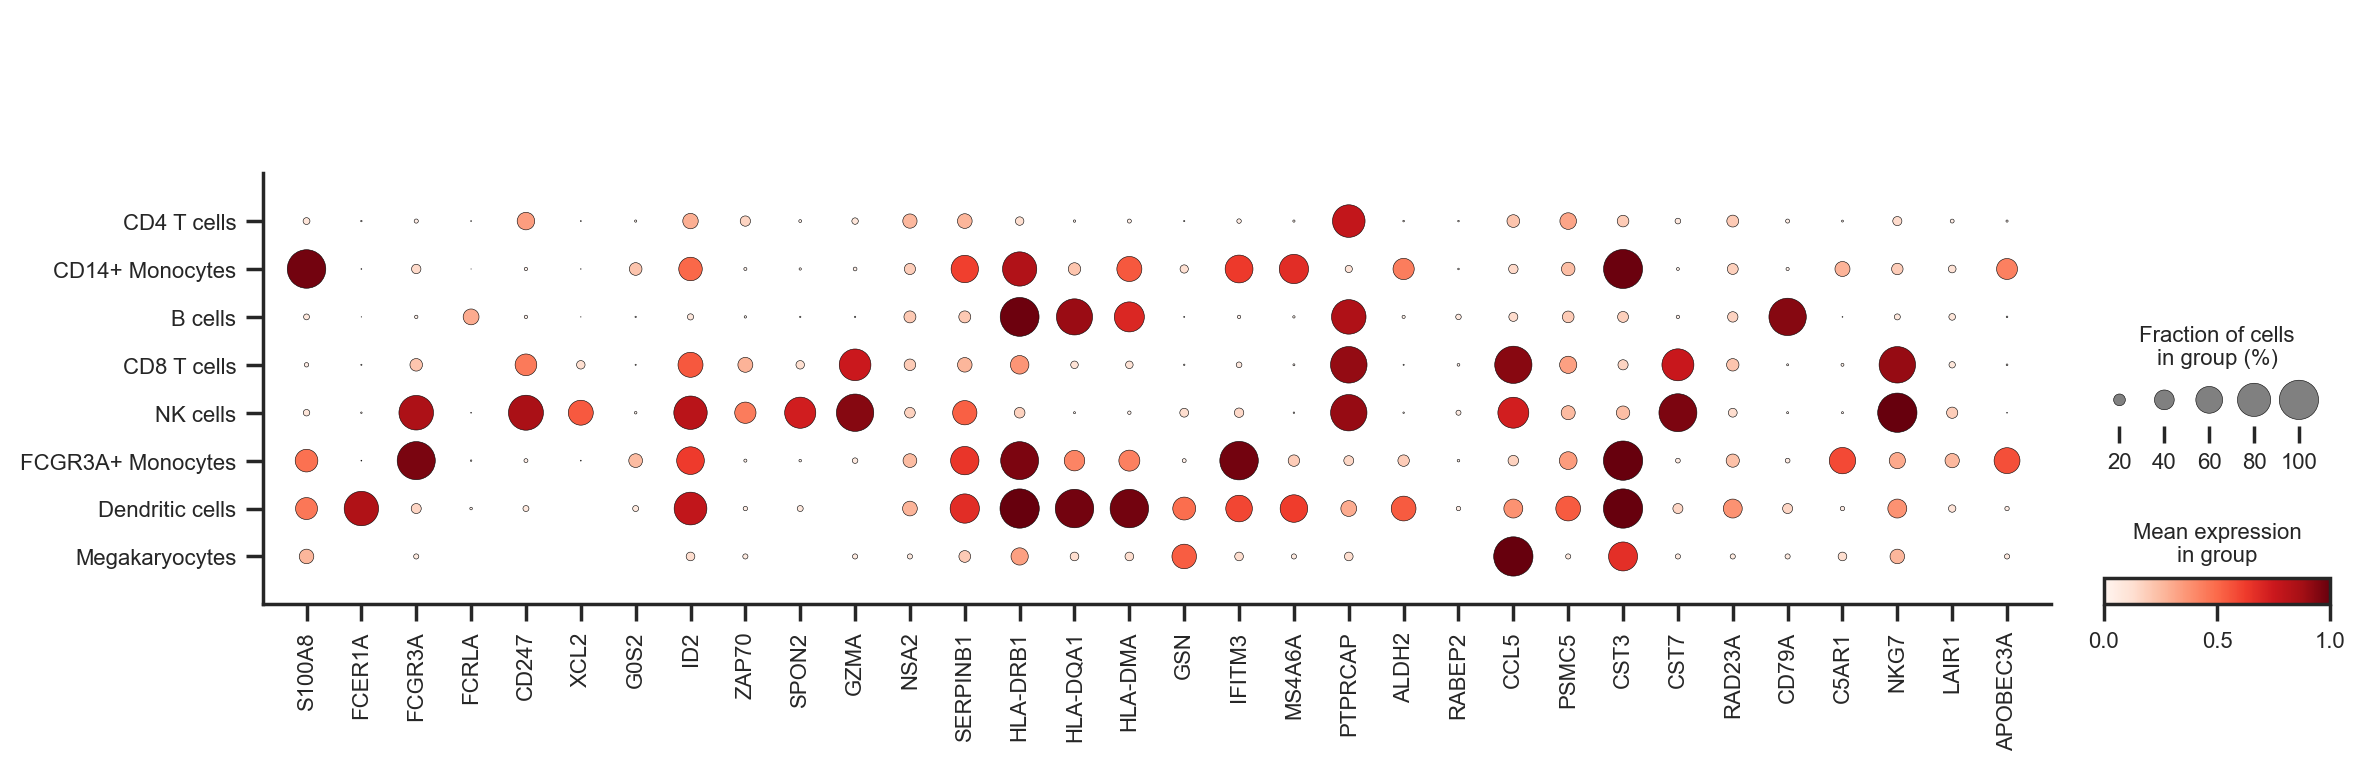

In [7]:
# Plot average binarized expression pattern for selection across cell types:
gene_set_32 = df[df['persist_set_32']].index.values
sc.pl.dotplot(adata,
              var_names=gene_set_32,
              groupby='louvain',
              layer='bin')
plt.show()

Set of 32 genes selected by PERSIST
--------  Validation set: ---------


,precision,recall,f1-score,support
CD4 T cells,0.93,0.95,0.94,229.0
CD14+ Monocytes,0.99,0.93,0.96,96.0
B cells,0.93,0.94,0.94,69.0
CD8 T cells,0.77,0.73,0.75,64.0
NK cells,0.75,0.70,0.72,30.0
FCGR3A+ Monocytes,0.83,1.00,0.91,30.0
Dendritic cells,0.62,0.71,0.67,7.0
Megakaryocytes,0.00,0.00,0.00,3.0
accuracy,0.90,0.90,0.90,0.9
macro avg,0.73,0.75,0.74,528.0



--------  Overall: ---------


,precision,recall,f1-score,support
CD4 T cells,0.95,0.96,0.95,1144.00
CD14+ Monocytes,0.95,0.95,0.95,480.00
B cells,0.98,0.96,0.97,342.00
CD8 T cells,0.82,0.80,0.81,316.00
NK cells,0.86,0.84,0.85,154.00
FCGR3A+ Monocytes,0.83,0.88,0.85,150.00
Dendritic cells,0.89,0.89,0.89,37.00
Megakaryocytes,1.00,0.40,0.57,15.00
accuracy,0.92,0.92,0.92,0.92
macro avg,0.91,0.84,0.86,2638.00


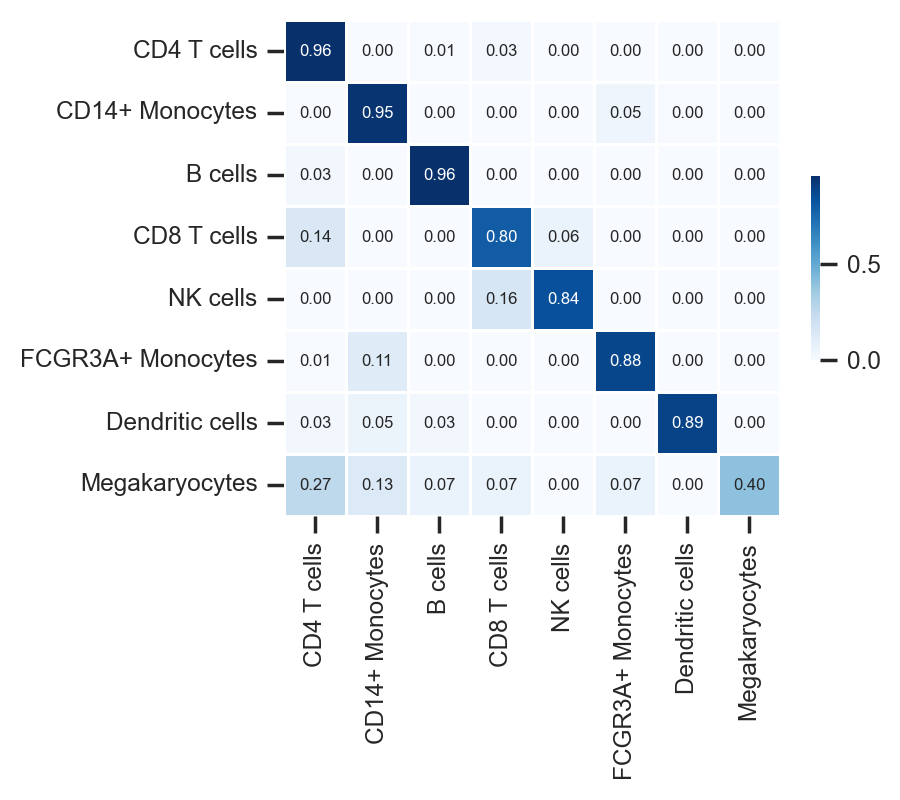

In [8]:
# Train a logistic regression classifier using only the selected genes

from sklearn.linear_model import LogisticRegression

selected_genes = df.index[df["persist_set_32"]]

# Train a logistic regression classifier using only the selected genes
clf = LogisticRegression(max_iter=1000)
clf.fit(adata_train[:, selected_genes].layers['bin'], adata_train.obs['louvain_id'])

# Evaluate the classifier on the entire dataset
score = clf.score(adata[:, selected_genes].layers['bin'], adata.obs['louvain_id'])


print(f"Set of {len(selected_genes)} genes selected by PERSIST")

print("--------  Validation set: ---------")
y_true = adata_val.obs['louvain_id']
y_pred = clf.predict(adata_val[:, selected_genes].layers['bin'])
report = sk.metrics.classification_report(y_true, y_pred, target_names=adata.obs['louvain'].cat.categories, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).T
display(report_df.round(2))

print("\n--------  Overall: ---------")
y_true = adata.obs['louvain_id']
y_pred = clf.predict(adata[:, selected_genes].layers['bin'])
report = sk.metrics.classification_report(y_true, y_pred, target_names=adata.obs['louvain'].cat.categories, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).T
display(report_df.round(2))

# get normalized confusion matrix
cm = sk.metrics.confusion_matrix(y_true, y_pred, normalize='true')
cm_df = pd.DataFrame(cm, index=adata.obs['louvain'].cat.categories, columns=adata.obs['louvain'].cat.categories)


f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm_df, annot=True, fmt='.2f', annot_kws={"size": 6},
            square=True, linewidth=0.5, cmap='Blues', ax=ax, cbar_kws={'shrink': 0.3})


plt.show()
